# Spatially varying anisotropy (using a Python function)

**Author** Hans Fangohr, images Max Albert

** Date** Jan 2013, updated Jan 2015 (Max Albert)

**Purpose** Demonstrate how material parameters can vary as a function of space.

In [1]:
import time ; print("Last time executed {}".format(time.asctime()))

Last time executed Mon Feb  9 13:33:17 2015


In [2]:
%matplotlib inline

In [3]:
import os
import pylab
import finmag
import numpy as np
import dolfin as df

from finmag import Simulation
from finmag.energies import UniaxialAnisotropy, Exchange, Demag

[2015-02-09 13:33:21] DEBUG: Building modules in 'native'...
[2015-02-09 13:33:22] DEBUG: FinMag          5744:84a0a07daeae9ac9cc2a4217595b5014f4709be3
[2015-02-09 13:33:22] DEBUG: Dolfin          1.4.0                Matplotlib      1.4.0               
[2015-02-09 13:33:22] DEBUG: Numpy           1.8.2                Scipy           0.14.0              
[2015-02-09 13:33:22] DEBUG: IPython         3.0.0-dev            Python          2.7.6               
[2015-02-09 13:33:22] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2015-02-09 13:33:22] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.1 LTS  
[2015-02-09 13:33:22] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


Demonstrating spatially varying anisotropy. Example with anisotropy vectors as follows:

```
-----------------------------------

--> --> --> --> --> --> --> --> -->
--> --> --> --> --> --> --> --> -->
--> --> --> --> --> --> --> --> -->

-----------------------------------

^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
|  |  |  |  |  |  |  |  |  |  |  | 
|  |  |  |  |  |  |  |  |  |  |  | 

-----------------------------------
```

Define the material constants...

In [4]:
mu0   = 4.0 * np.pi * 10**-7  # vacuum permeability             N/A^2
Ms    = 1.0e6                 # saturation magnetisation        A/m
A     = 13.0e-12              # exchange coupling strength      J/m
Km    = 0.5 * mu0 * Ms**2     # magnetostatic energy density scale   kg/ms^2
lexch = (A/Km)**0.5           # exchange length                 m
K1    = Km*0.1

... and the mesh geometry.

In [5]:
L = lexch # cube length in m
nx = 10
Lx = nx*L
ny = 1
Ly = ny*L
nz = 30
Lz = nz*L
mesh = df.BoxMesh(0, 0, 0, Lx, Ly, Lz, nx, ny, nz)

In [6]:
# Anisotropy direction starts is [0,0,1] in lower half of the film
# and [1,0,0] in upper half. This is a toy model of the exchange spring
# systems that Bob Stamps is working on.

def expr_a(pt):
    x, y, z = pt
    if z <= 0.5*Lz:
        return [0, 0, 1]
    else:
        return [1, 0, 0]
    
# Alternatively, one can use the following dolfin Expression, but this is much less readable.
#
#expr_a = df.Expression((\"x[2]<=Lz/2. ? 0 : 1\",\"0\", \"x[2]<=Lz/2. ? 1 : 0\"), Lz=Lz)

We can directly use this Python function to create a `UniaxialAnisotropy` object which gets added to our simulation.

In [7]:
sim = Simulation(mesh, Ms)
sim.set_m([1, 0, 1])
sim.add(UniaxialAnisotropy(K1, expr_a))
sim.add(Exchange(A))

[2015-02-09 13:33:26] INFO: Finmag logging output will be written to file: '/home/cilix/work/code/finmag/doc/ipython_notebooks_src/unnamed.log' (any old content will be overwritten).
[2015-02-09 13:33:26] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2015-02-09 13:33:26] INFO: Creating Sim object 'unnamed' (rank=0/1).
[2015-02-09 13:33:26] INFO: <Mesh of topological dimension 3 (tetrahedra) with 682 vertices and 1800 cells, ordered>
[2015-02-09 13:33:26] DEBUG: Creating LLG object.
[2015-02-09 13:33:26] DEBUG: Creating UniaxialAnisotropy object with method box-matrix-petsc,  in Jacobian.
[2015-02-09 13:33:26] DEBUG: Adding interaction Anisotropy to simulation.
[2015-02-09 13:33:26] DEBUG: Creating Exchange object with method box-matrix-petsc,  in Jacobian.
[2015-02-09 13:33:26] DEBUG: Adding interaction Exchange to simulation.


Run the simulation for 1 ns...

In [8]:
#sim.relax()
sim.run_until(1e-9)

[2015-02-09 13:33:28] INFO: Simulation will run until t = 1e-09 s.
[2015-02-09 13:33:28] INFO: Creating integrator with backend sundials and arguments {'reltol': 1e-06, 'abstol': 1e-06}.
[2015-02-09 13:33:28] DEBUG: Updating get method for steps in TableWriter(name=unnamed.ndt)
[2015-02-09 13:33:28] DEBUG: Updating get method for last_step_dt in TableWriter(name=unnamed.ndt)
[2015-02-09 13:33:28] DEBUG: Updating get method for dmdt in TableWriter(name=unnamed.ndt)
[2015-02-09 13:33:50] INFO: Simulation has reached time t = 1e-09 s.


... and plot the result.

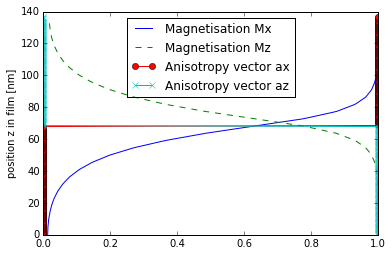

In [9]:
# Create a simple plot
xpos=[]
Mx = []
Mz = []
ax = []
az = []

## For plotting, we probe the field at 200 points
## along a line in z-direction.
probing_pts, probed_vals = \
    sim.probe_field_along_line('m',
                               [Lx/2., Ly/2., 0],
                               [Lx/2., Ly/2, Lz],
                               N=200)
zs = probing_pts[:, 2]
Mx = probed_vals[:, 0]
Mz = probed_vals[:, 2]

## We also evaluate the original profile 
a_vals = np.array([expr_a(pos) for pos in probing_pts])
ax = a_vals[:, 0]
az = a_vals[:, 2]
    
pylab.plot(Mx, zs/1e-9, '-', label='Magnetisation Mx')
pylab.plot(Mz, zs/1e-9, '--', label='Magnetisation Mz')
pylab.plot(ax, zs/1e-9, '-o', label='Anisotropy vector ax')
pylab.plot(az, zs/1e-9, '-x', label='Anisotropy vector az')
pylab.ylabel('position z in film [nm]')
pylab.legend(loc='upper center')

#this only works with an X-display, so comment out for jenkins
#v = df.plot(sim.llg._m, 
#            title='exchange spring across layers with different anisotropy directions',
#            axes=True)

#v.elevate(-90) 
#v.update(sim.llg._m)    # bring settings above into action
##v.write_png(os.path.join(MODULE_DIR,'exchangespring.png')) #this is broken in my dolfin, HF
#                                                            #the bitmap looks random  
#v.write_ps(os.path.join(MODULE_DIR,'exchangespring'))       #will write exchangespring.eps
#os.system("ps2png exchangespring.eps exchangespring.png")   #create the png file for documentation

[2015-02-09 13:33:51] DEBUG: Saved field at t=1e-09 to file '/tmp/tmp8ykWqc/paraview_scene_unnamed.pvd' (snapshot #0; saving took 0.00402 seconds).


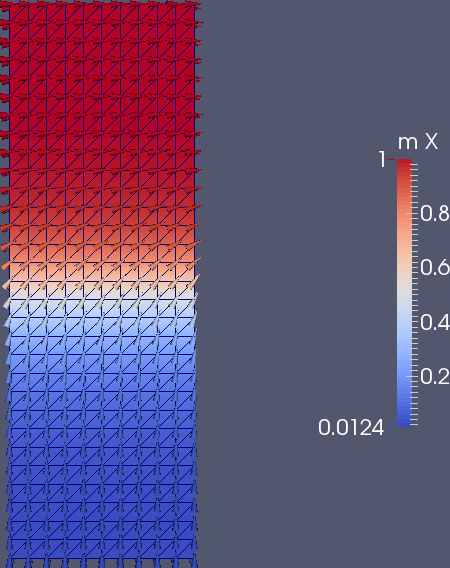

In [10]:
sim.render_scene(camera_position=[0, -200, 0])